# Predicing Healthcare related infections
### Capstone 2
__EDA - Exploratory data analysis__

Data science process: <br>
Problem identification > Data wrangling > __EDA__ > Pre-processing and training > Modeling >
Documentation

This is a continuation from prior work, for details on data sets see:
https://github.com/rejexx/Predicting_infection/blob/main/01_DataWrangling.ipynb

#### Significance:

"At any given time, about 1 in 25 inpatients have an infection related to hospital care. These infections lead to tens of thousands of deaths and cost the U.S. health care system billions of dollars each year." - https://health.gov/our-work/health-care-quality/health-care-associated-infections

In [39]:
#Imports
#Math, stats and modeling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn import __version__ as sklearn_version
import sklearn

#Viz tools
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns # For all our visualization needs.
import plotly.express as px

In [40]:
HAI_tidy = pd.read_csv(".\data\HAI_tidy_Wrangled.csv")

display(HAI_tidy.shape)
with pd.option_context('display.max_columns', None):
    display(HAI_tidy.sort_values(by="Facility ID").head(2))
#display(HAI_tidy.columns)

(3096, 77)

Facility ID  HAI_1_CILOWER  HAI_1_CIUPPER  HAI_1_DOPC  HAI_1_ELIGCASES  \
0      010001          0.301          1.543      7846.0            8.086   
1      010005            NaN          1.507      3088.0            1.988   

   HAI_1_NUMERATOR  HAI_1_SIR_Score  HAI_2_CILOWER  HAI_2_CIUPPER  HAI_2_DOPC  \
0              6.0            0.742          0.131          0.675     13268.0   
1              0.0            0.000          0.393          2.378      7928.0   

   HAI_2_ELIGCASES  HAI_2_NUMERATOR  HAI_2_SIR_Score  HAI_3_CILOWER  \
0           18.498              6.0            0.324          0.165   
1            4.660              5.0            1.073          0.025   

   HAI_3_CIUPPER  HAI_3_DOPC  HAI_3_ELIGCASES  HAI_3_NUMERATOR  \
0          1.769       165.0            4.615              3.0   
1          2.504        74.0            1.970              1.0   

   HAI_3_SIR_Score  HAI_4_CILOWER  HAI_4_CIUPPER  HAI_4_DOPC  HAI_4_ELIGCASES  \
0            0.650            NaN           1.59       216.0            1.884   
1            0.508            NaN            NaN        31.0            0.244   

   HAI_4_NUMERATOR  HAI_4_SIR_Score  HAI_5_CILOWER  HAI_5_CIUPPER  HAI_5_DOPC  \
0              0.0              0.0          0.174          1.321    102765.0   
1              0.0              NaN          0.493          5.274     40143.0   

   HAI_5_ELIGCASES  HAI_5_NUMERATOR  HAI_5_SIR_Score  HAI_6_CILOWER  \
0            7.305              4.0            0.548          0.391   
1            1.548              3.0            1.938          0.247   

   HAI_6_CIUPPER  HAI_6_DOPC  HAI_6_ELIGCASES  HAI_6_NUMERATOR  \
0          0.722    102765.0           76.294             41.0   
1          1.118     37697.0           12.386              7.0   

   HAI_6_SIR_Score          HAI_1_SIR_ComparedToNational  \
0            0.537  No Different than National Benchmark   
1            0.565  No Different than National Benchmark   

           HAI_2_SIR_ComparedToNational          HAI_3_SIR_ComparedToNational  \
0    Better than the National Benchmark  No Different than National Benchmark   
1  No Different than National Benchmark  No Different than National Benchmark   

           HAI_4_SIR_ComparedToNational          HAI_5_SIR_ComparedToNational  \
0  No Different than National Benchmark  No Different than National Benchmark   
1                                   NaN  No Different than National Benchmark   

           HAI_6_SIR_ComparedToNational                     Facility Name  \
0    Better than the National Benchmark  SOUTHEAST ALABAMA MEDICAL CENTER   
1  No Different than National Benchmark          MARSHALL MEDICAL CENTERS   

                      Address    City State  ZIP Code County Name  \
0      1108 ROSS CLARK CIRCLE  DOTHAN    AL     36301     HOUSTON   
1  2505 U S HIGHWAY 431 NORTH    BOAZ    AL     35957    MARSHALL   

     Phone Number                      Location  H_CLEAN_STAR_RATING  \
0  (334) 793-8701  POINT (-85.361725 31.214058)                  3.0   
1  (256) 593-8310                           NaN                  2.0   

   H_COMP_1_STAR_RATING  H_COMP_2_STAR_RATING  H_COMP_3_STAR_RATING  \
0                   3.0                   3.0                   3.0   
1                   3.0                   4.0                   3.0   

   H_COMP_5_STAR_RATING  H_COMP_6_STAR_RATING  H_COMP_7_STAR_RATING  \
0                   3.0                   4.0                   3.0   
1                   3.0                   4.0                   3.0   

   H_HSP_RATING_STAR_RATING  H_QUIET_STAR_RATING  H_RECMND_STAR_RATING  \
0                       3.0                  4.0                   4.0   
1                       3.0                  4.0                   3.0   

   H_STAR_RATING  H_CLEAN_LINEAR_SCORE  H_COMP_1_LINEAR_SCORE  \
0            3.0                  87.0                   90.0   
1            3.0                  85.0                   91.0   

   H_COMP_2_LINEAR_SCORE  H_COMP_3_LINEAR_

From prior step, this was the plan:

* Most likley option as prediction goal is the HAI_5_SIR - this is normalized MRSA infections.
    * MRSA infections are a big issue for hospitals right now, large task force working to solve
    * HAI SIR data is normalized already a cross hospitals, making it a better canadite than infections observed per hospital
* After Exploratory data analysis, I expect to drop rows with no HAI_5_SIR score, as well as many of the derivative features for HAIs that came with the initial dataset, such as upper and lower bounds.  

## Clean up columns
First step is to pull out some description columns that may be helpful for the final presentation, but aren't needed for the model, such as phone number, location (long/lat), Facility Name, etc... below.

In [41]:
HAI_tidy['County_State'] = HAI_tidy['County Name'] + ', ' + HAI_tidy.State #Combine county, since some counties are the same between states
HAI_EDA = HAI_tidy.drop(['Phone Number', 'Location', 'Facility Name', 'Address', 'City', 'County Name'], axis="columns")

HAI_EDA.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3096 entries, 0 to 3095
Data columns (total 72 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Facility ID                   3096 non-null   object 
 1   HAI_1_CILOWER                 1648 non-null   float64
 2   HAI_1_CIUPPER                 1971 non-null   float64
 3   HAI_1_DOPC                    3020 non-null   float64
 4   HAI_1_ELIGCASES               3020 non-null   float64
 5   HAI_1_NUMERATOR               3020 non-null   float64
 6   HAI_1_SIR_Score               1971 non-null   float64
 7   HAI_2_CILOWER                 1883 non-null   float64
 8   HAI_2_CIUPPER                 2219 non-null   float64
 9   HAI_2_DOPC                    3031 non-null   float64
 10  HAI_2_ELIGCASES               3031 non-null   float64
 11  HAI_2_NUMERATOR               3031 non-null   float64
 12  HAI_2_SIR_Score               2219 non-null   float64
 13  HAI

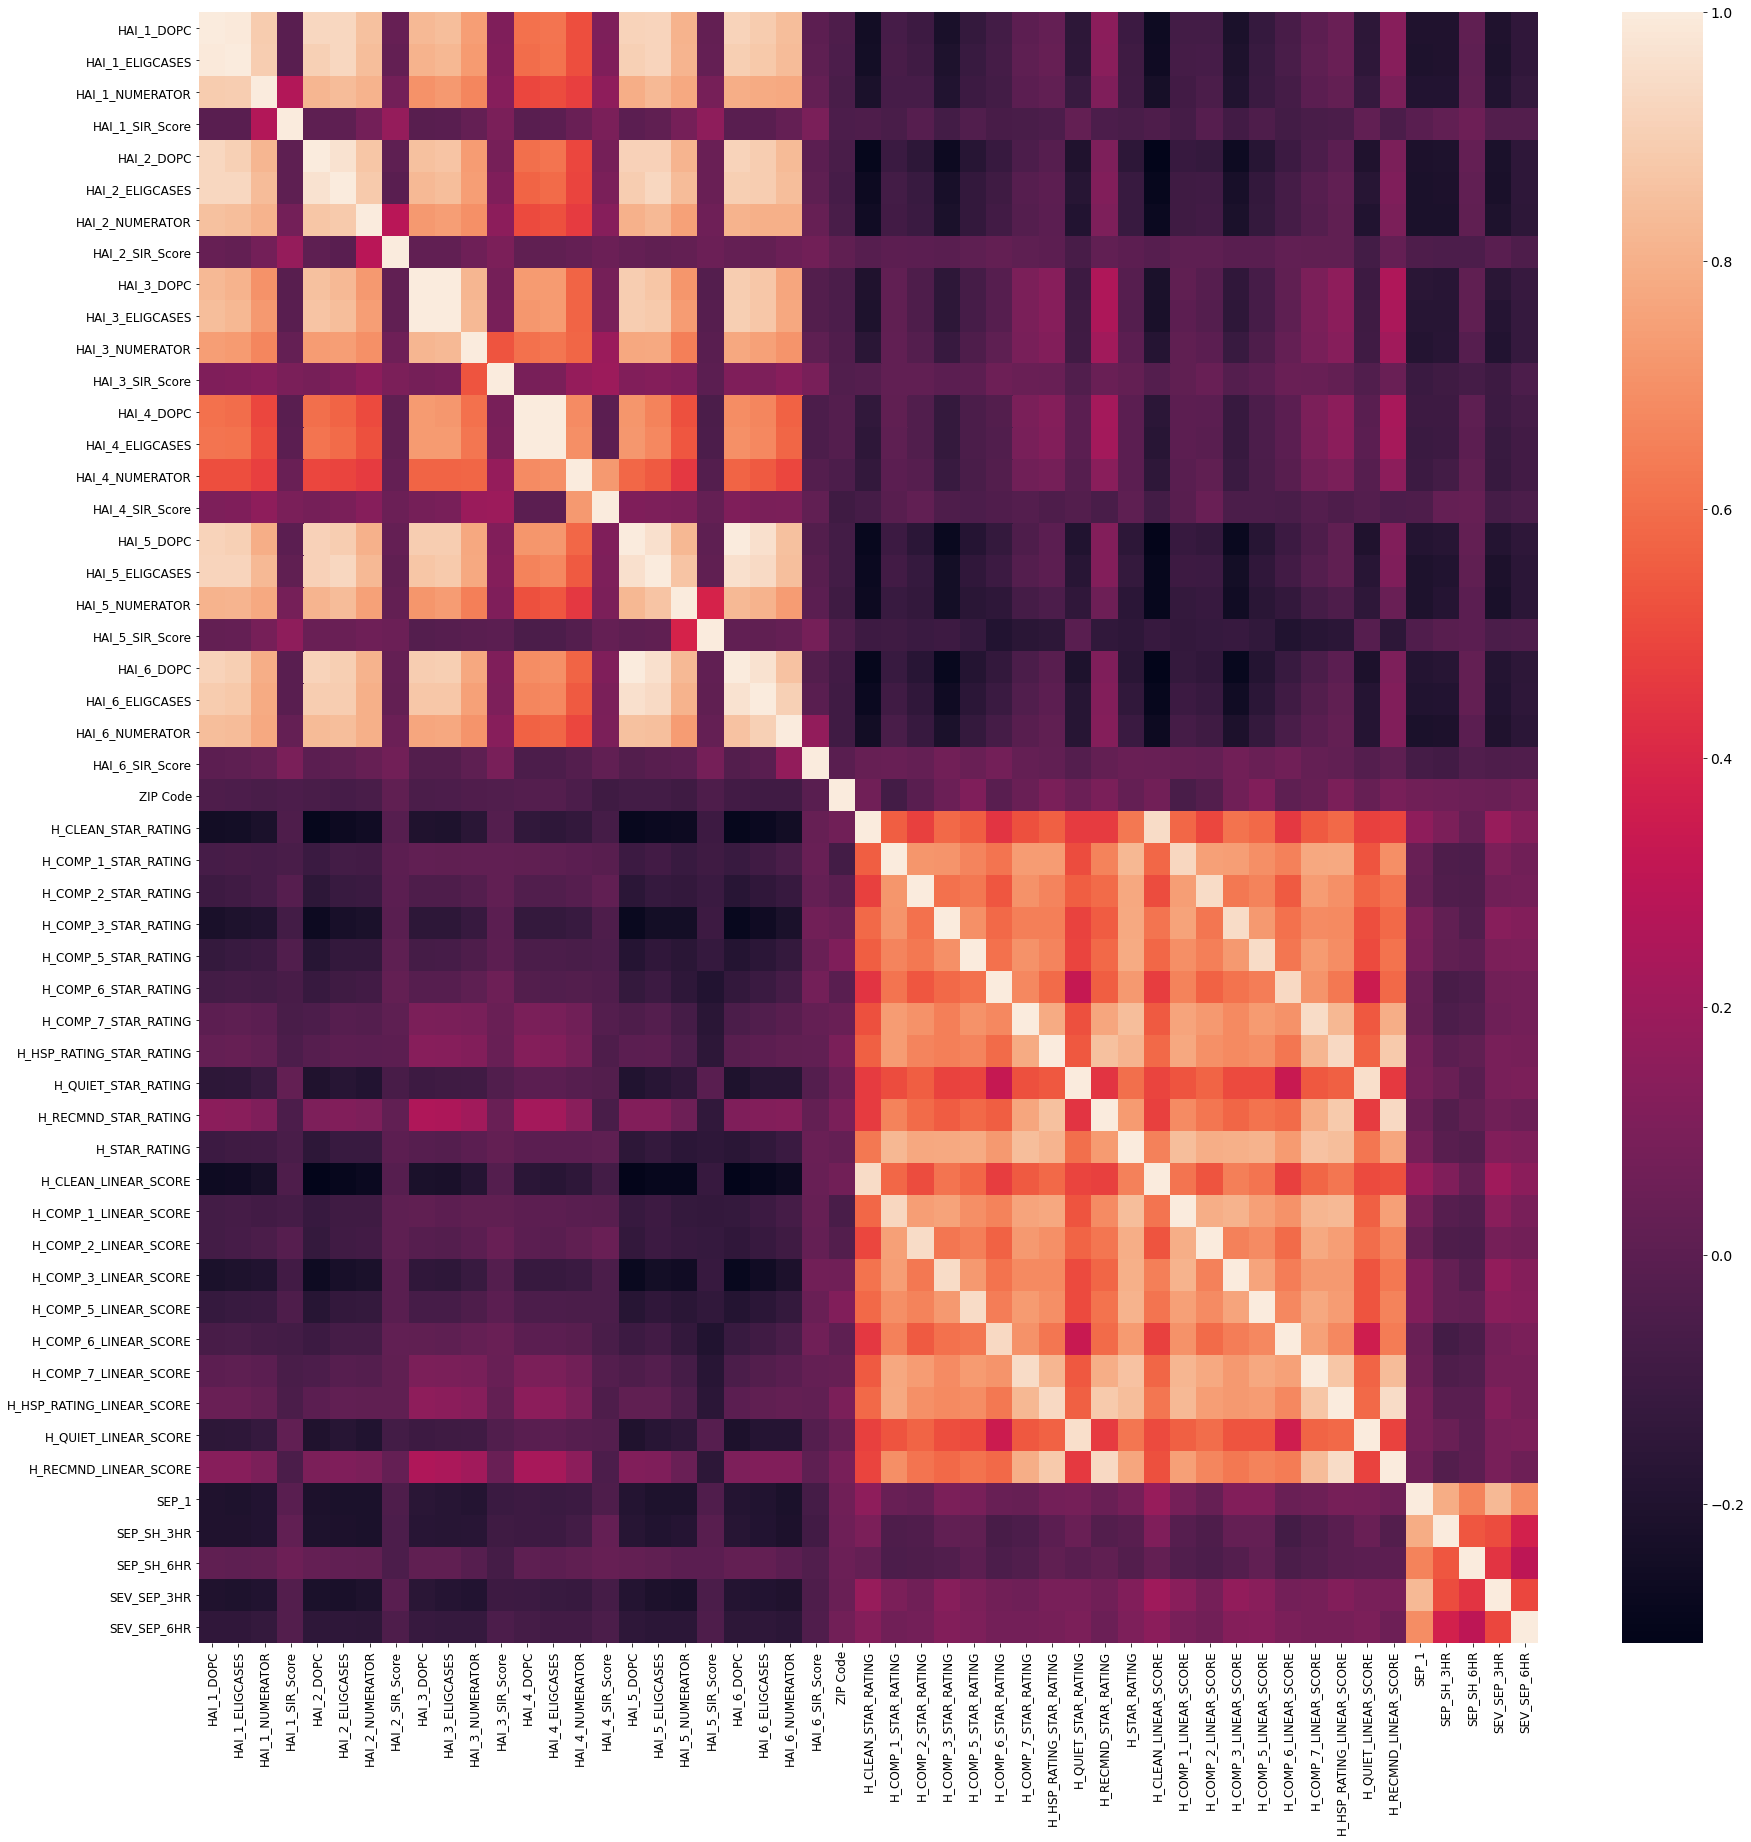

In [42]:
#Heat map of current data correlation
#Drop upper and lower limts from HAI data
HAI_EDA_noLimits = HAI_EDA[HAI_EDA.columns.drop(HAI_EDA.filter(regex='CILOWER|CIUPPER').columns )]

#get only numeric variables
HAI_EDA_noLimits = HAI_EDA_noLimits.select_dtypes(include=np.number)  #Referenced https://stackoverflow.com/questions/25039626/how-do-i-find-numeric-columns-in-pandas

#Plot help: https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
fig, ax = plt.subplots(figsize=(30,30))         # Sample figsize in inches
font = {'family' : 'ariel',
        'size'   : 14}
plt.rcParams.update({'font.size': 14})

sns.heatmap(HAI_EDA_noLimits.corr(), ax=ax);

Above heatmap shows several things
    
* It's hard to see correlations with so many columns
* HAI numbers correlate with each other
* H_COMP survey numbers correlate positively with each other
* Sepsis treatment numbers correlate with sepsis treatment numbers

This indicates the three data sets I've joined all have autocorrelation, but don't connect well outside of themselves.
The main outlier to this is the H_RECMND_LINEAR_SCORE and equivalent star rating.  These mostly correlate with the non-normalized HAI numbers (DOPC, Eligible cases, numerator (observed cases)) which I think is related to patient count, a lurking variable.

More in depth, I'd hypothesize that the HAI numbers that correlate are related to hospital size
* I.e. A large hospital will have a higher observable and eligible number for all types of infections just because they have more patients overall. 
* More patients leading to more infections sounds a little like a Poisson probability.
* These values are a bit of a false lead, they aren't necessarily helping anything.

In [43]:
filterString = 'DOPC|ELIGCASES|NUMERATOR'
HAI_EDA_slim = HAI_EDA_noLimits[HAI_EDA_noLimits.columns.drop(HAI_EDA_noLimits.filter(regex=filterString).columns )]

print(HAI_EDA_slim.columns)
HAI_EDA_slim.shape

Index(['HAI_1_SIR_Score', 'HAI_2_SIR_Score', 'HAI_3_SIR_Score',
       'HAI_4_SIR_Score', 'HAI_5_SIR_Score', 'HAI_6_SIR_Score', 'ZIP Code',
       'H_CLEAN_STAR_RATING', 'H_COMP_1_STAR_RATING', 'H_COMP_2_STAR_RATING',
       'H_COMP_3_STAR_RATING', 'H_COMP_5_STAR_RATING', 'H_COMP_6_STAR_RATING',
       'H_COMP_7_STAR_RATING', 'H_HSP_RATING_STAR_RATING',
       'H_QUIET_STAR_RATING', 'H_RECMND_STAR_RATING', 'H_STAR_RATING',
       'H_CLEAN_LINEAR_SCORE', 'H_COMP_1_LINEAR_SCORE',
       'H_COMP_2_LINEAR_SCORE', 'H_COMP_3_LINEAR_SCORE',
       'H_COMP_5_LINEAR_SCORE', 'H_COMP_6_LINEAR_SCORE',
       'H_COMP_7_LINEAR_SCORE', 'H_HSP_RATING_LINEAR_SCORE',
       'H_QUIET_LINEAR_SCORE', 'H_RECMND_LINEAR_SCORE', 'SEP_1', 'SEP_SH_3HR',
       'SEP_SH_6HR', 'SEV_SEP_3HR', 'SEV_SEP_6HR'],
      dtype='object')


(3096, 33)

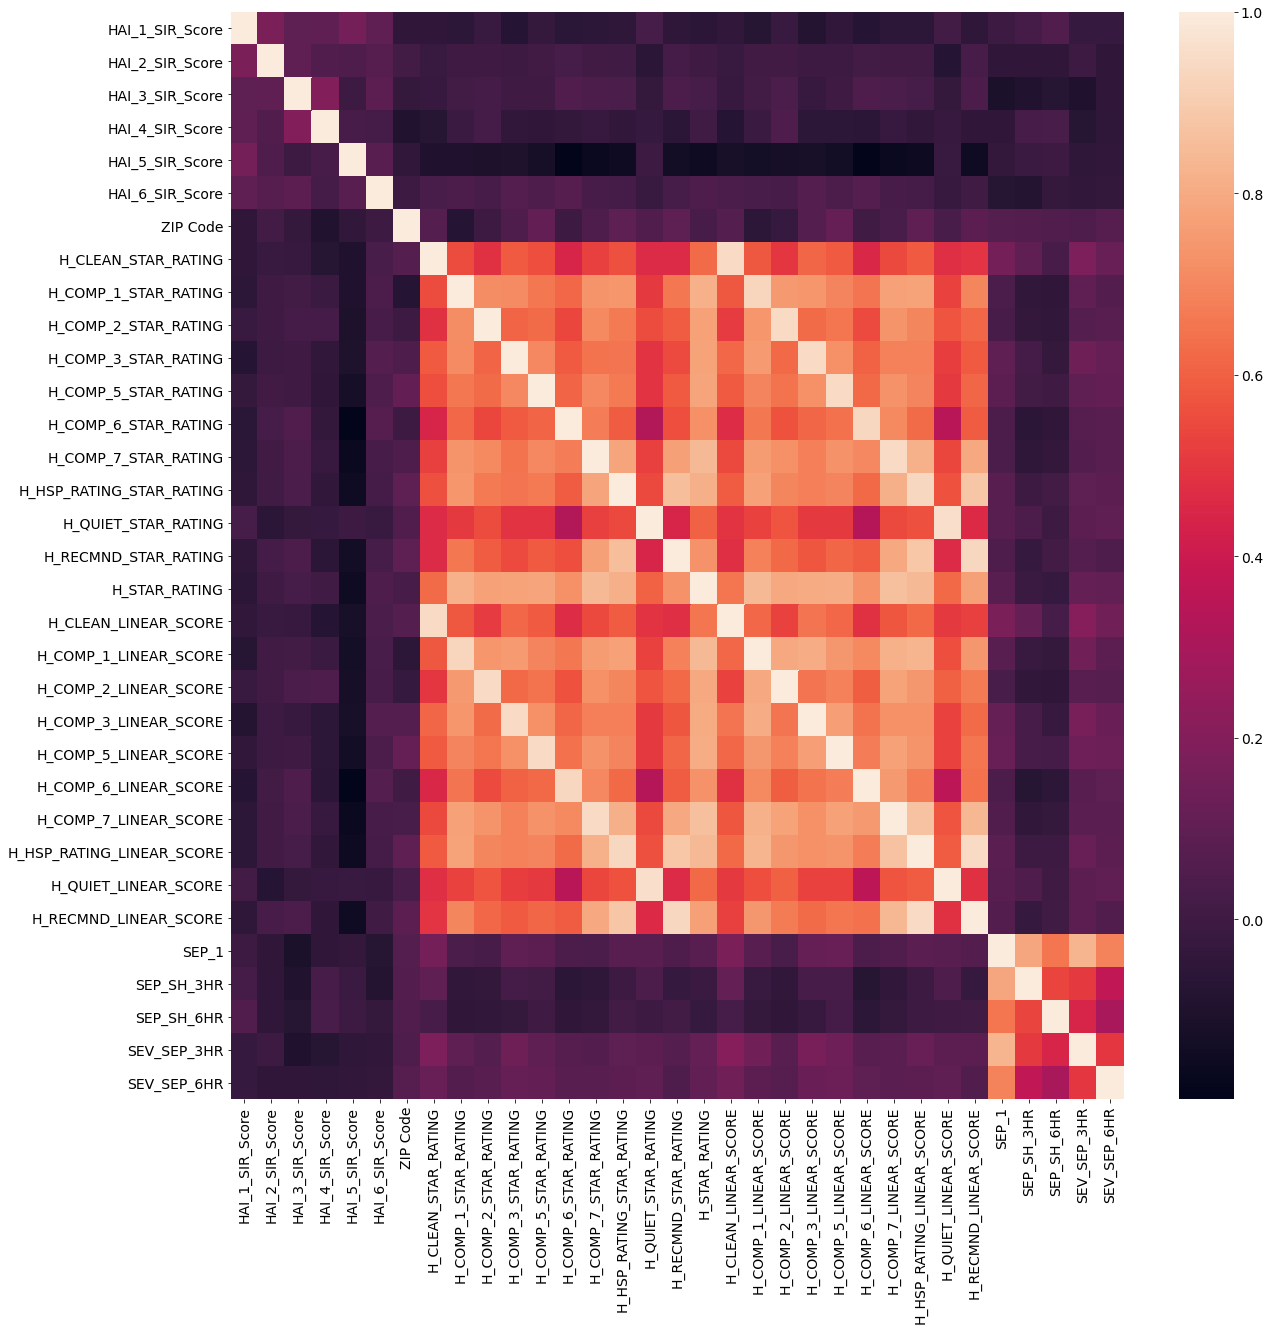

In [44]:
fig, ax = plt.subplots(figsize=(20,20))         # Sample figsize in inches
sns.heatmap(HAI_EDA_slim.corr());

## Survey rating data

H_COMP data set contains some semi-duplicate data.  The star ratings and linear mean scores.  The linear mean score is a pre-
processing step output. 


 >HCAHPS survey responses are first converted to linear mean scores for each HCAHPS measure and then adjusted for patient mix and mode of survey administration. Next, a statistical clustering algorithm groups hospitals into 5 star categories for each HCAHPS measure. For more details, please see the Technical Notes for HCAHPS Star Ratings, which can be found on the official HCAHPS On-Line Web site . CMS assigns 1,2,3,4, or 5 whole stars for each HCAHPS measure by applying statistical methods that use relative distribution and clustering. 
 <br> Source: https://data.cms.gov/provider-data/topics/hospitals/hcahps#about-the-hcahps-survey

In other words, using the star data adjusts for patient mix and mode of survey administration, which sounds beneficial.  However, this alters from continous to categorical data, which may be less helpful for the final model.  I'll keep both sets around and test with that in the pre-processing stage, but plan to only use a single set (either mean score or star rating).

In [45]:
filterString = 'LINEAR|STAR'
H_COMP = HAI_EDA_noLimits[HAI_EDA_noLimits.filter(regex=filterString).columns ]

H_star = H_COMP[H_COMP.filter(regex='STAR').columns]
H_linear = H_COMP[H_COMP.filter(regex='LINEAR').columns]


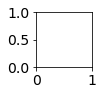

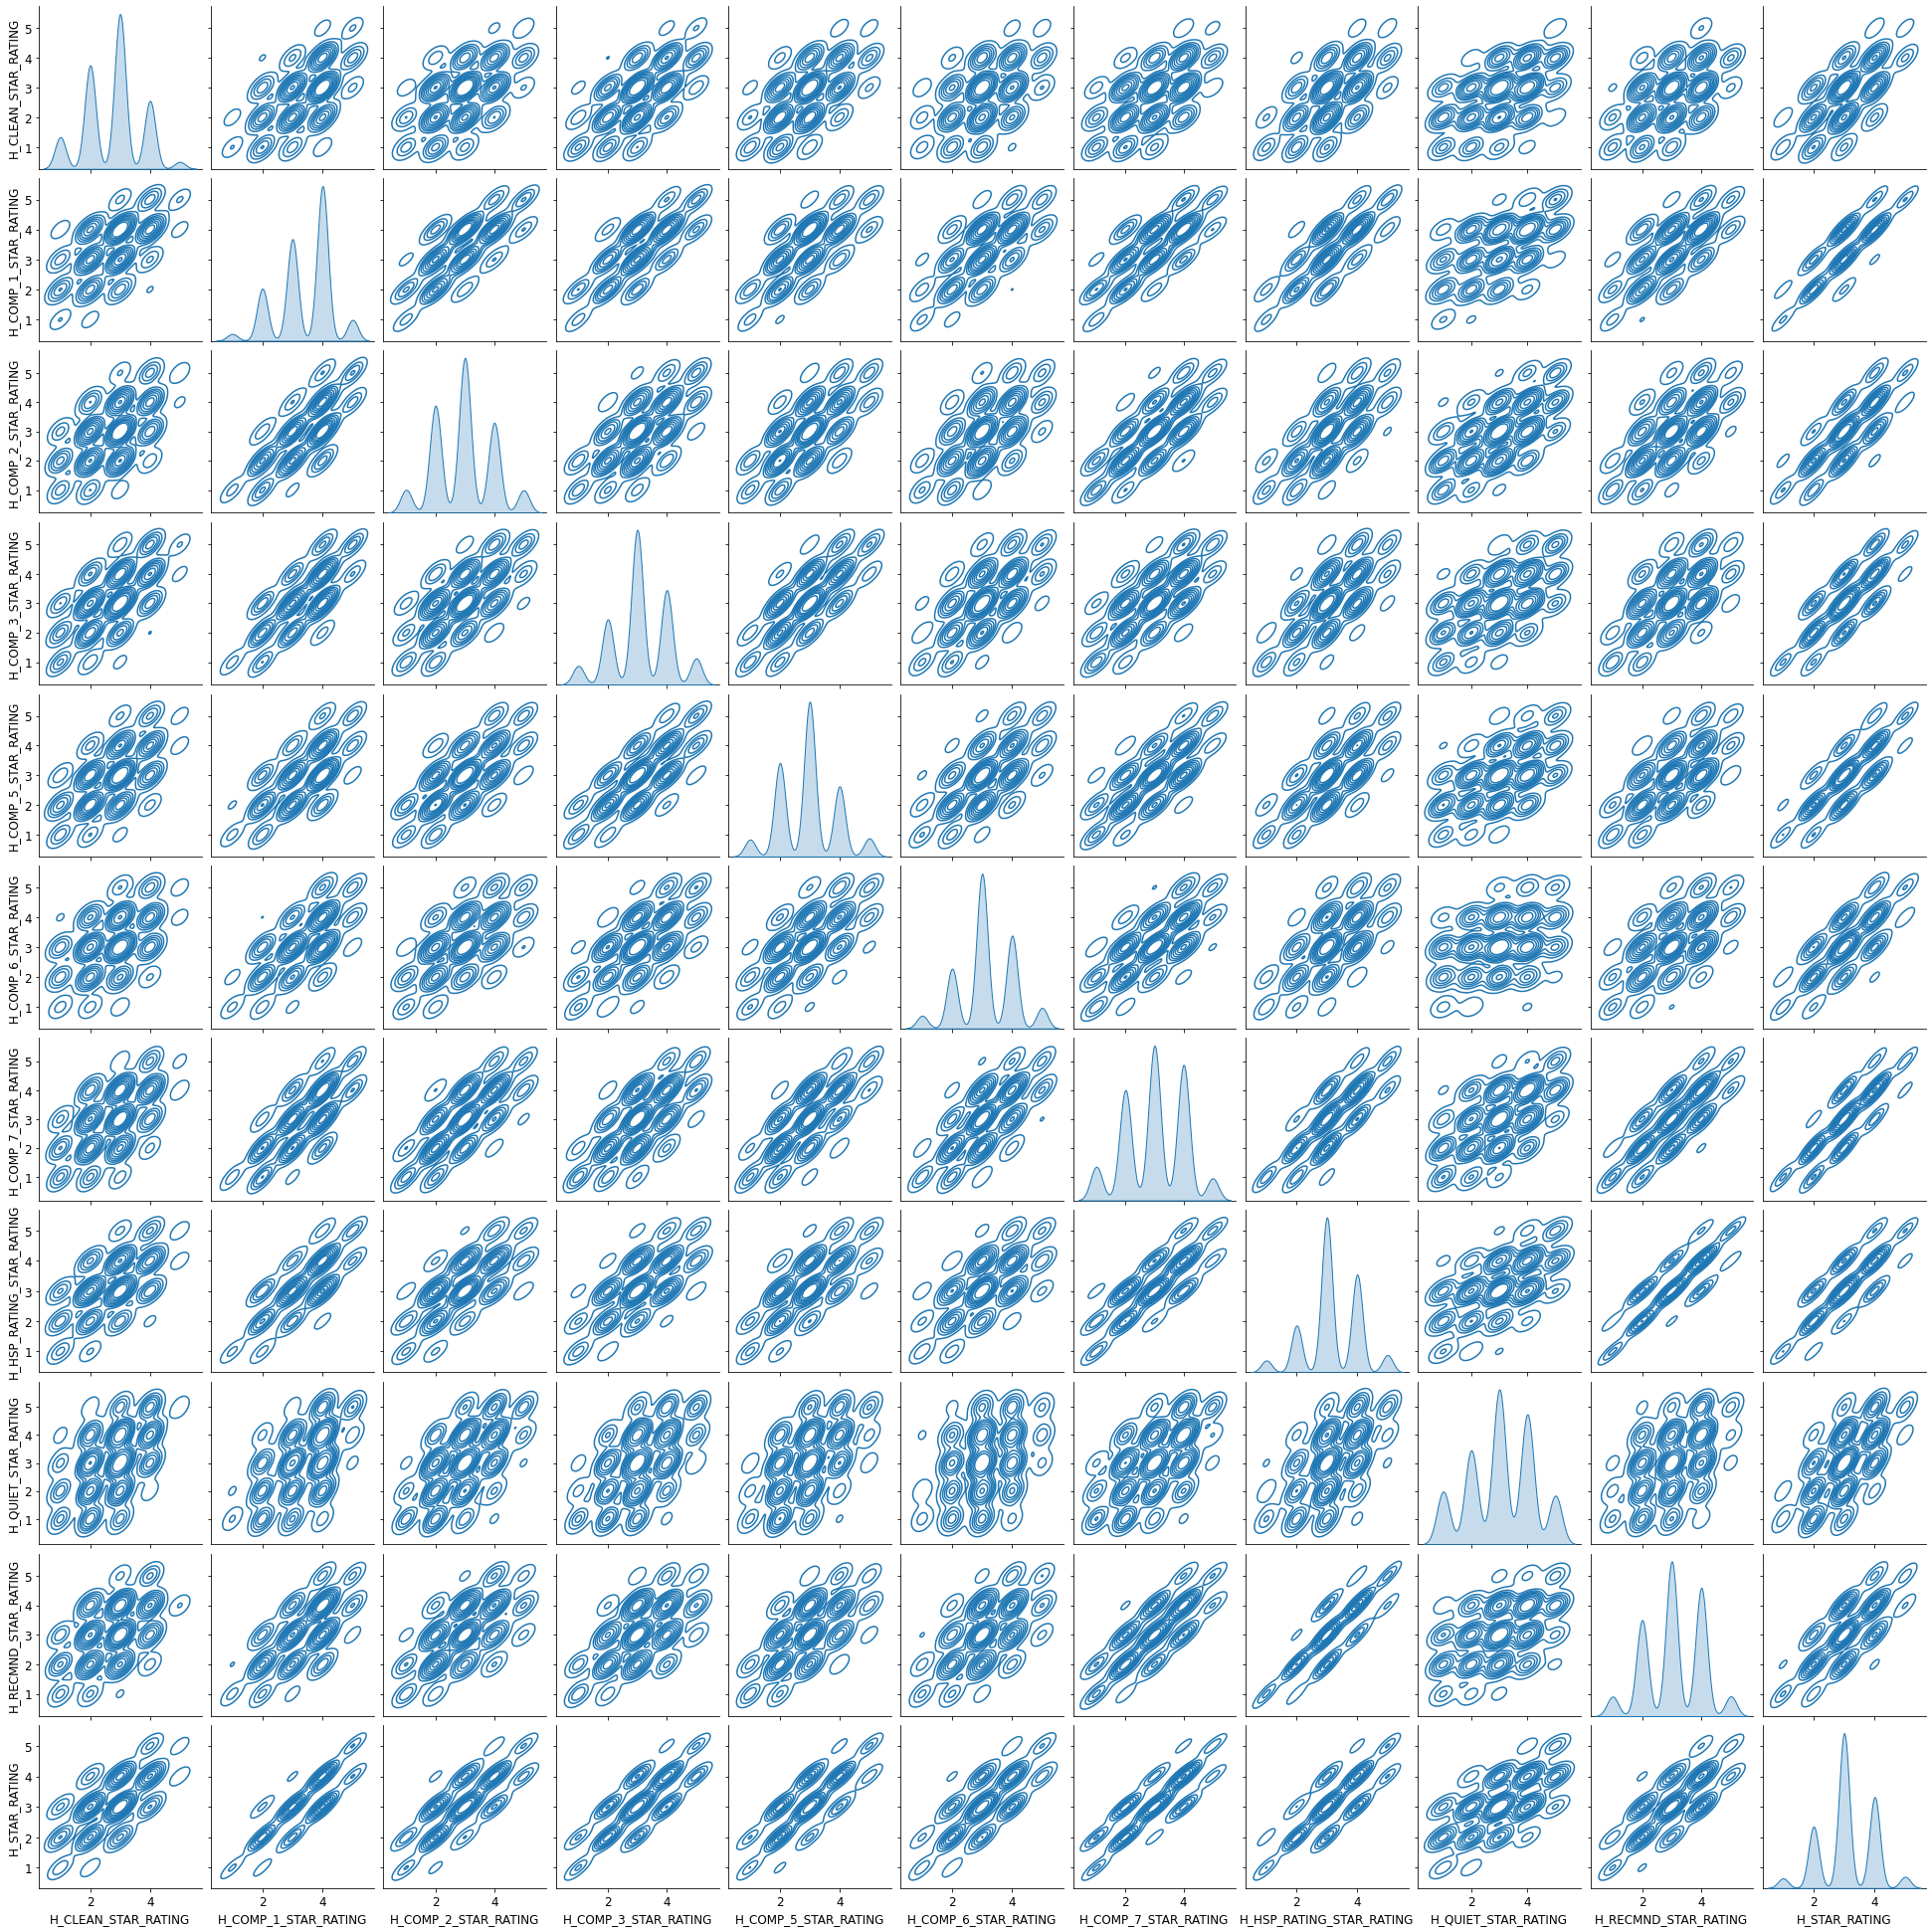

In [46]:
fig, ax = plt.subplots(figsize=(1,1))         # Sample figsize in inches
plt.rcParams.update({'font.size': 12})
sns.pairplot(H_star, kind='kde');

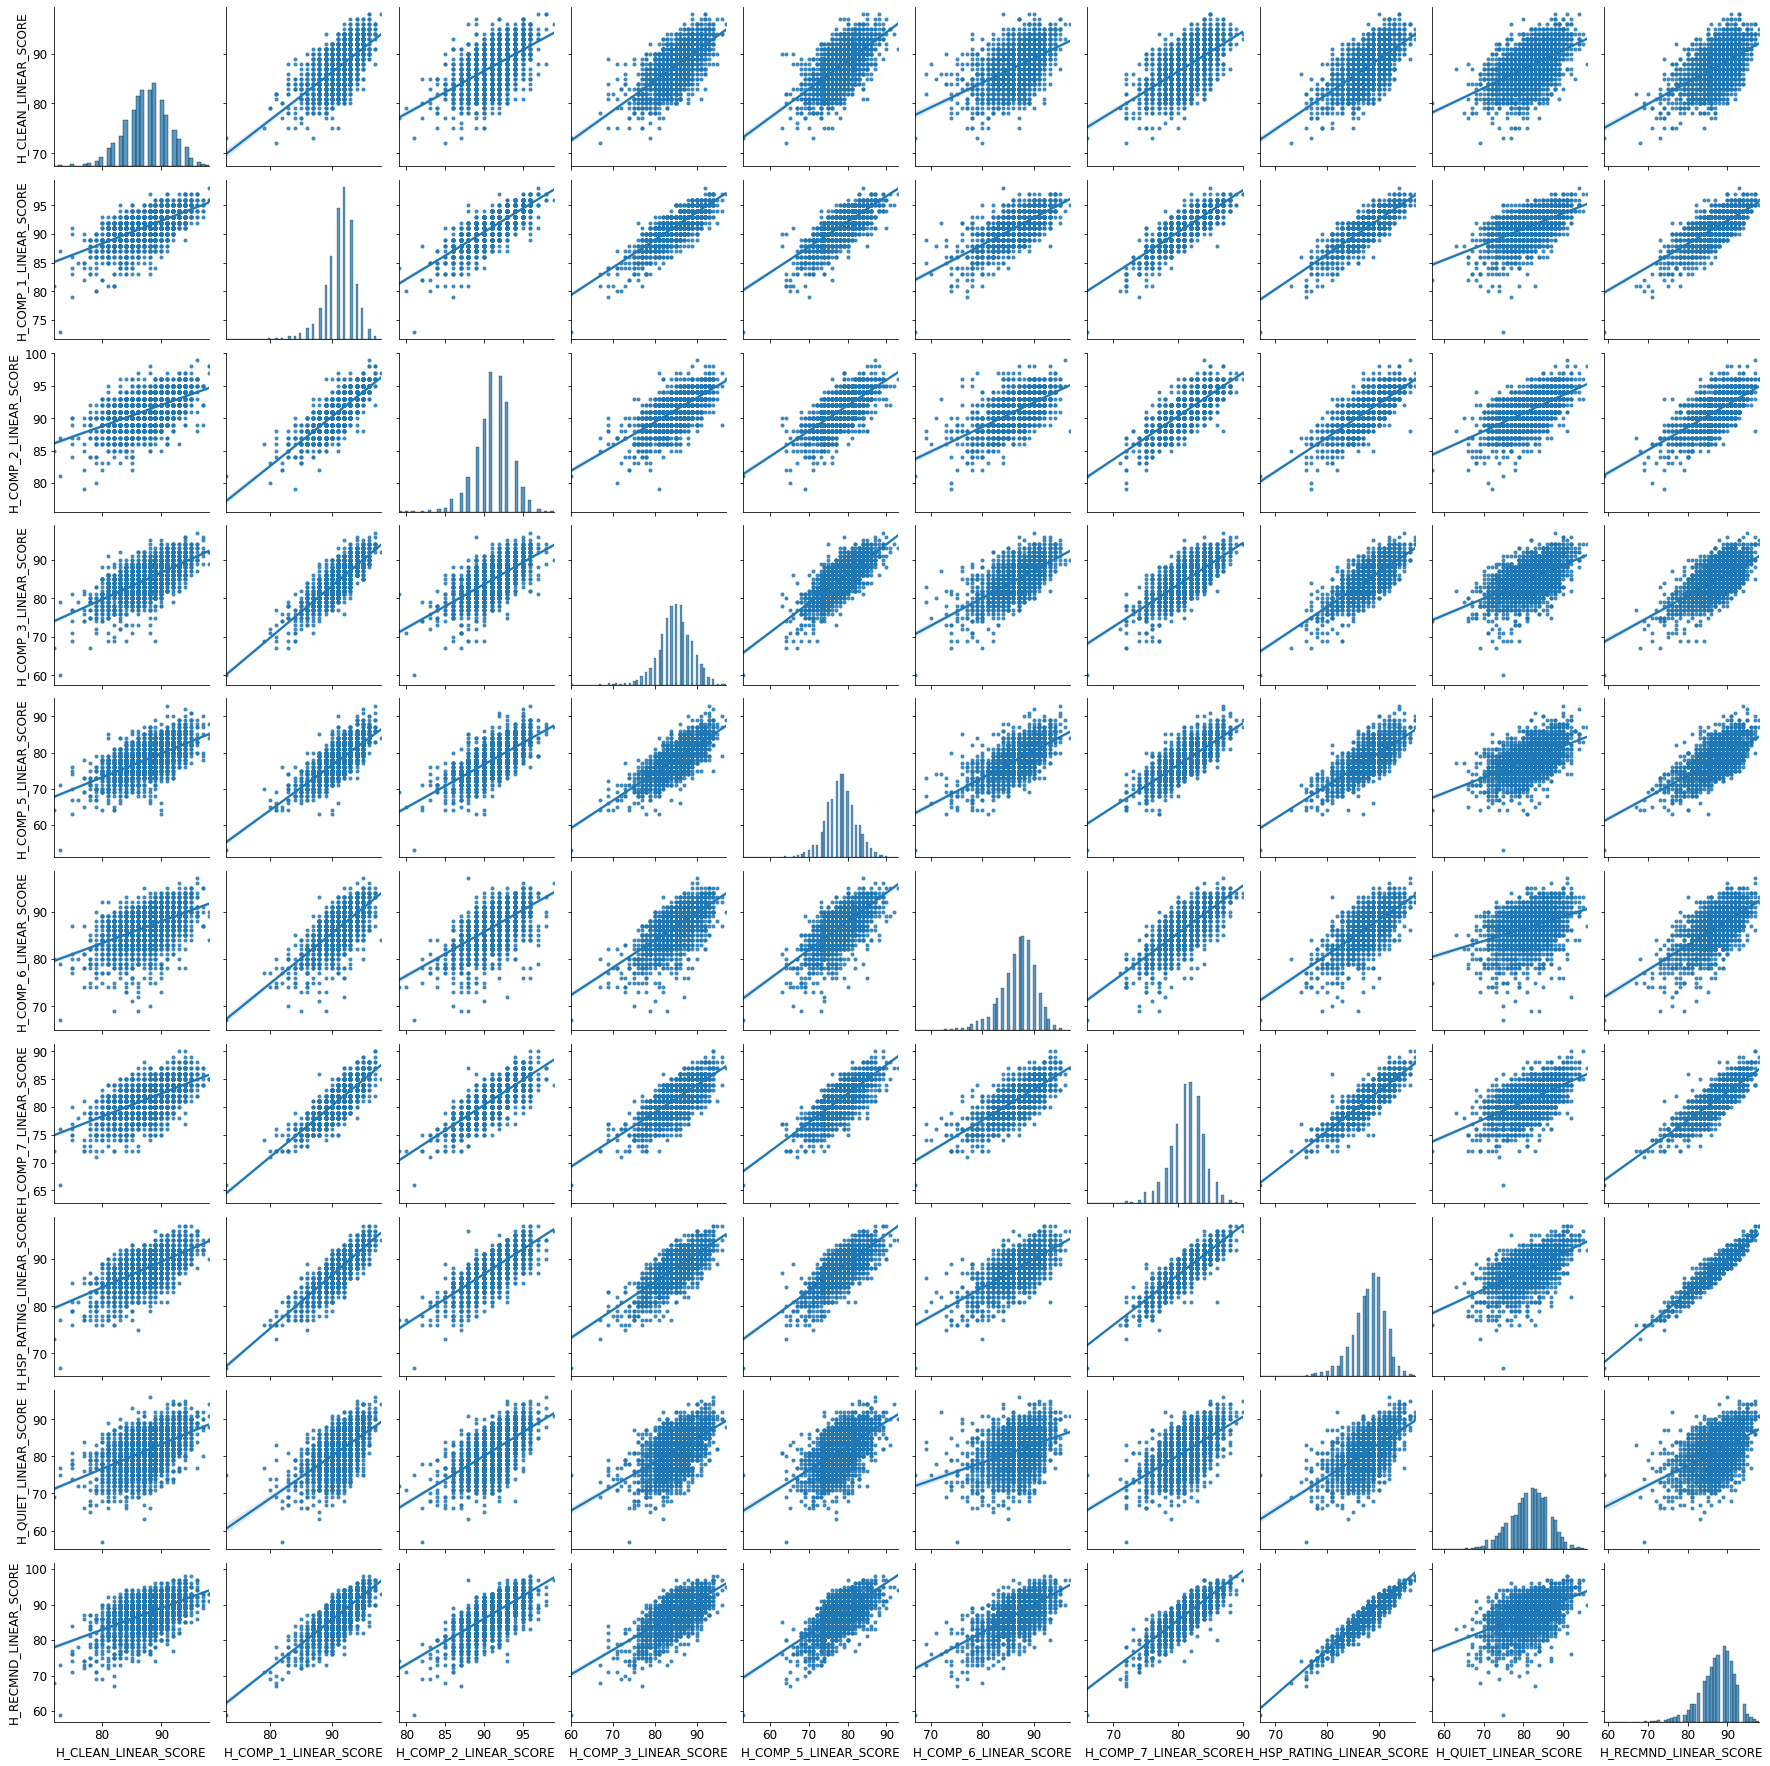

In [47]:
sns.pairplot(H_linear, kind='reg', markers='.');

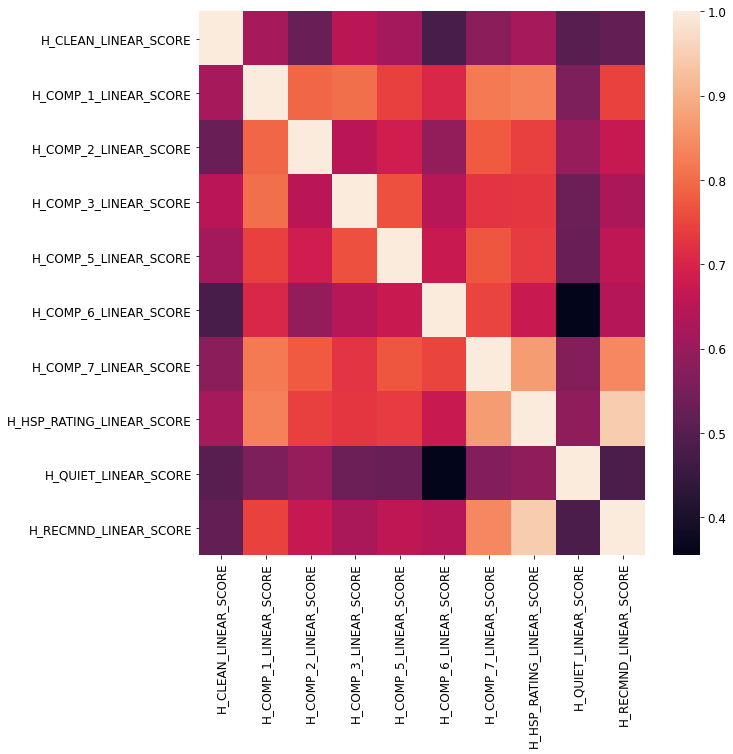

In [48]:
#Same data, different style.  
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches
sns.heatmap(H_linear.corr());

In [49]:
#sns.heatmap(np.corrcoef(H_linear, H_star.drop(columns='H_STAR_RATING')))
#Trying to determine orrelation between stars and linear ratings

__ Observations __
* It seems clear that all survey scores have a positive correlate with all the others to some degree.
* Data: Hospitals with higher scores tend to have higher scores in multiple fields.  
* Interpretation: hospitals that can treat patients well can do so on many levels, and the inverse is true.
* The apparent non-conformists here are cleanliness and quietness.  They both have larger variance and less correlation.
  * Perhaps hospitals have a hard time controlling this, or these are more objective to individual view points.

### HAI data

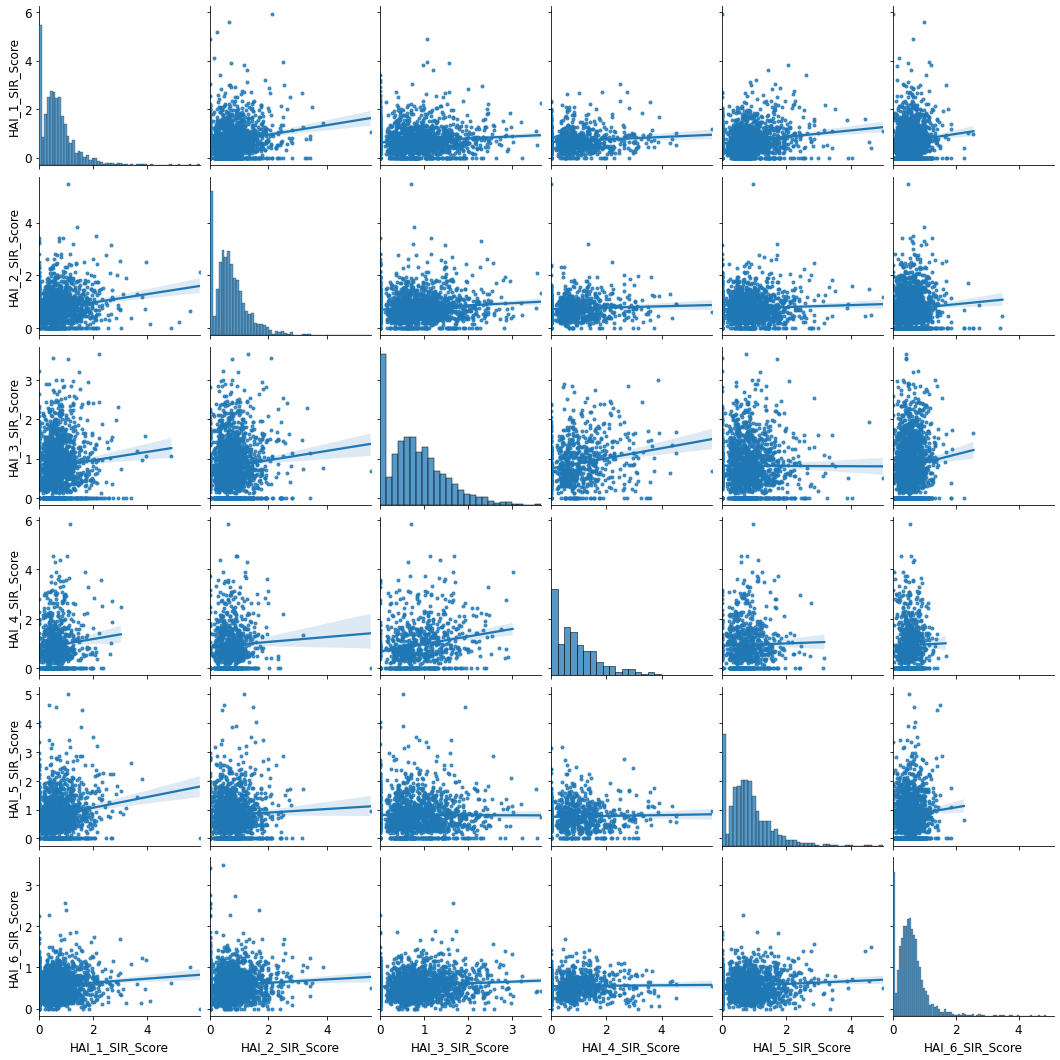

In [50]:
HAI_SIR = HAI_EDA_slim[HAI_EDA_slim.filter(regex='SIR').columns]
sns.pairplot(HAI_SIR, kind='reg', markers='.');

Look at top ranked hospitals vs bottom ranked hospitals and see if any of the HAI data cluster towards on or another

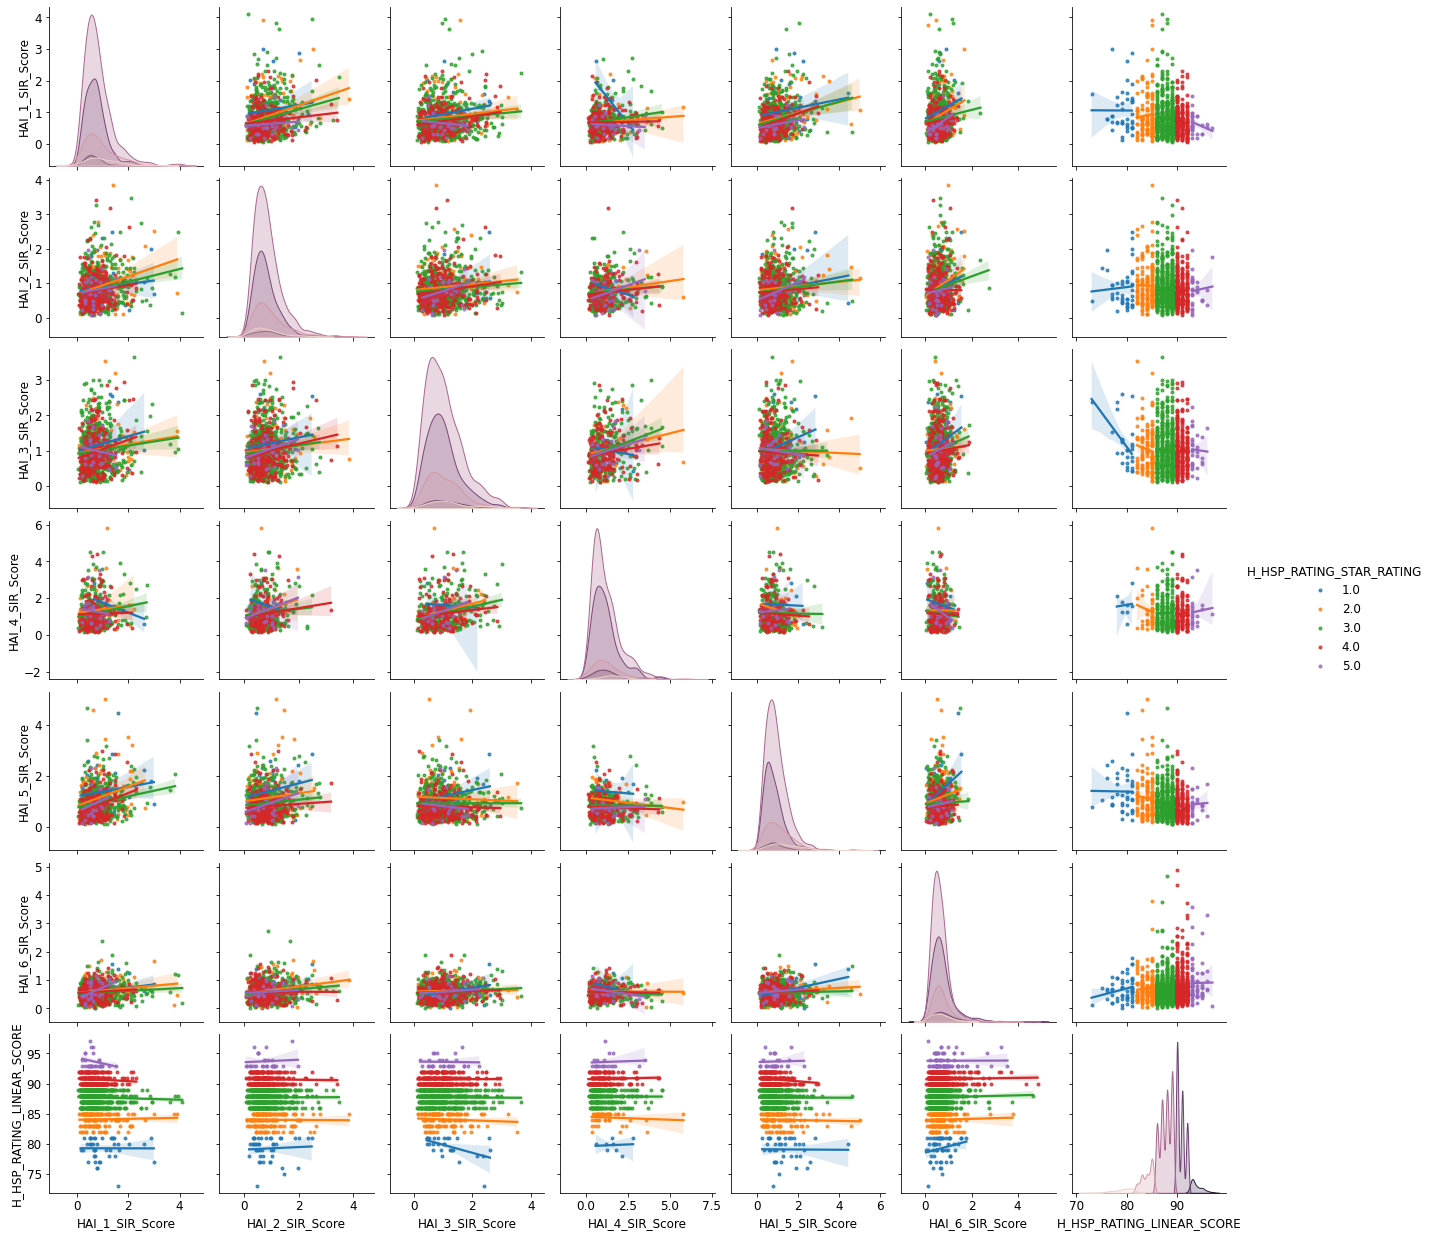

In [51]:
HAI_SIR = HAI_EDA_slim[HAI_EDA_slim.filter(regex='SIR|H_HSP_RATING').columns]
HAI_SIR_nozeros = HAI_SIR.loc[(HAI_SIR!=0).all(axis=1)]

#Pairplot with all 0 rows removed.  This drops about half the data.  
#  For just a viz it might be better to impute with the mean
sns.pairplot(HAI_SIR_nozeros, kind='reg', hue='H_HSP_RATING_STAR_RATING', markers='.', dropna=True);

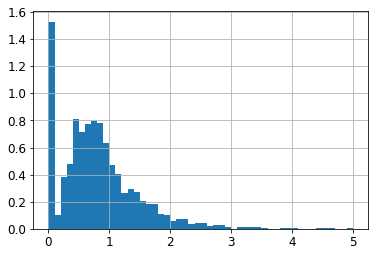

In [52]:
#Is HAI 5 SIR (MRSA infections score) normally distributed?
HAI_SIR.HAI_5_SIR_Score.hist(bins=50, density=True);

mean 0.945996990972919
variance 0.3599032158543902


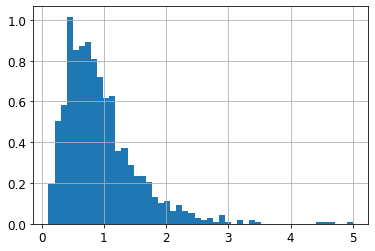

In [53]:
#Remove zeros
HAI_SIR_nozeros.HAI_5_SIR_Score.hist(bins=50, density=True);
print('mean', HAI_SIR_nozeros.HAI_5_SIR_Score.mean())
print('variance', HAI_SIR_nozeros.HAI_5_SIR_Score.var())

### Look at sepsis care data

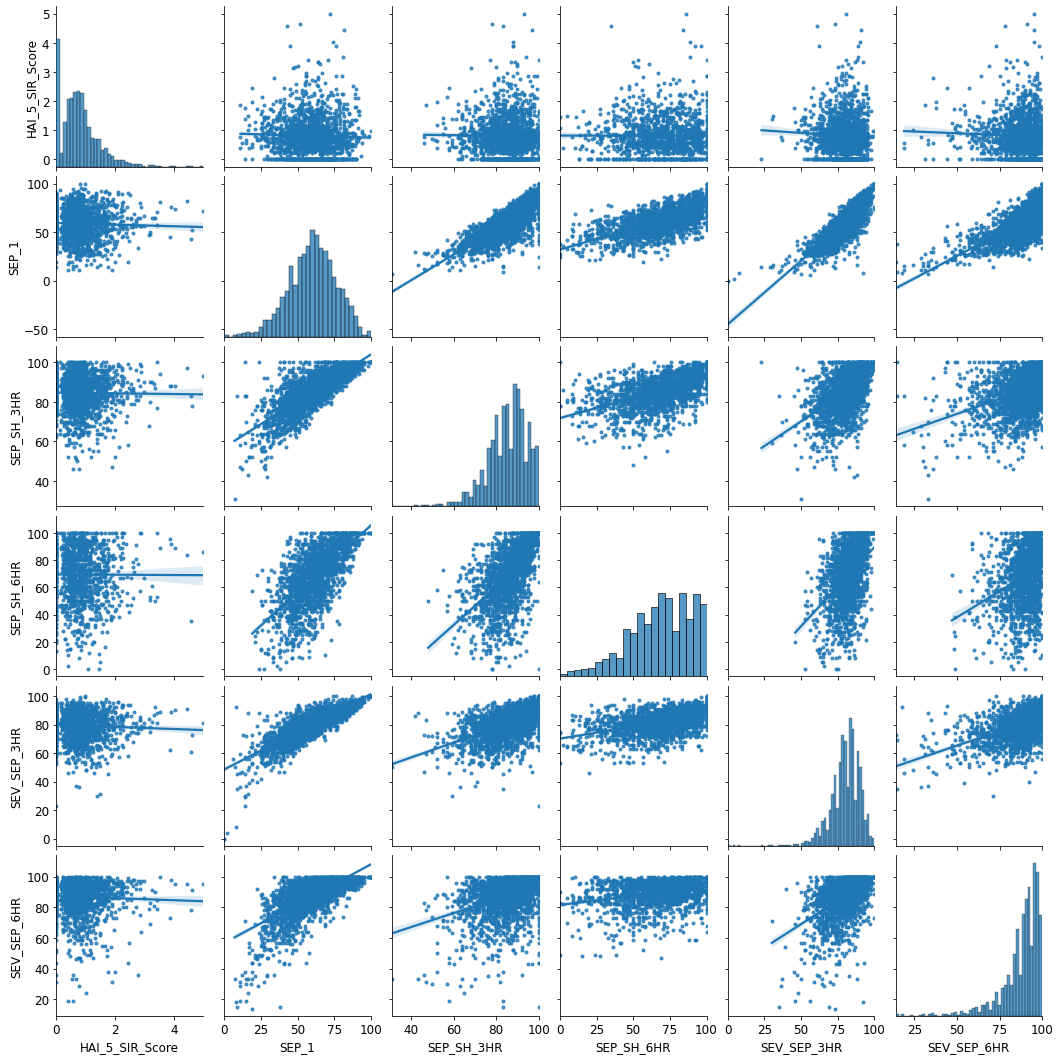

In [54]:
HAI_SEP = HAI_EDA_slim[HAI_EDA_slim.filter(regex='5_SIR|SEP').columns]
#HAI_SEP = HAI_SEP.loc[(HAI_SIR!=0).all(axis=1)]

#Pairplot with all 0 rows removed.  This drops about half the data.  
#  For just a viz it might be better to impute with the mean
sns.pairplot(HAI_SEP, kind='reg', markers='.', dropna=True);

It appears there is poor correlation between Sepsis treatment and MRSA infection scores.  

## Look at location (state, county and zip) data

In [55]:
#Credit to CS95 on SO : https://stackoverflow.com/questions/12589481/multiple-aggregations-of-the-same-column-using-pandas-groupby-agg/54300159#54300159
HAI_byState = HAI_EDA.groupby('State')['HAI_5_SIR_Score'].agg(count = 'count', average_HAI_5_SIR = 'mean').reset_index()
#df.groupby('kind')['height'].agg(max_height='max', min_height='min')    
#HAI_byState
px.bar(HAI_byState, x='State', y="count", title="Counts per state")


In [56]:
px.bar(HAI_byState, x='State', y="average_HAI_5_SIR", color = 'count', title="Average HAI 5 SIR score per state")


In [57]:
fig = px.scatter(HAI_byState, x='count', y='average_HAI_5_SIR', opacity=0.65, trendline='ols',
           trendline_color_override='darkblue', hover_name = "State")
fig.add_hline(y=HAI_byState.average_HAI_5_SIR.mean(), line_dash="dash", line_color="green")
fig.show()

Commenting on above chart.  Average is shown in green, OLS fit in dark blue.  This appears to be a 'regression to the mean' situation, where larger samples approach the mean, while small sampling bias dominates in the lower count space.  Florida is potentially an outlier.

## Summary

So far, theres no obvious feature that correlates well with HAI_5_SIR_Scores, 
which is the MRSA infection score normalized per hospital. The false positive on correlation is that 
the related values (eligible cases, observations, and DOPC) which are used to compute the SIR score _do_ correlate
which makes sense, since those values are used to compute the score in the first place.

Here's a few take aways
 * Each of the three original data sets have a significant amount of internal correlation, but limited cross-over to the others
 * State HAI_5_SIR_score show a typical funnel between count of participating facilities and average, showing a regression to the mean seems true here.  Larger datasets are closer to the population mean.
     * We can see some positive correlations between different lengths of sepsis care, indicating hospitals that are good at short or longterm care are typically good at both
     * We see positive correlation with different survey rankings, indicating good scores in one area is correlated with good scores in another.
     * The main correlation with HAI data is the population values - number of cases and observations between types of HAIs are correlated.  In other words, hospitals with many MRSA infections may also see many catheter infections.  This is probably because these data are not normalized for patient count.  After normalizing, we get the SIR score, which does not have those types of correlations.  
     
__Future EDA__ related to the last bullet, it would be good to do some normalizing with available data and see if the same lack of correlation occurs.

__Next steps in data science workflow__

It seems like a good time to re-evaluate the feature being predicted.  With such a lack of correlation, I doubt theres a way to make good predictions with the available data.  But it's worth trying anyway I suppose. 